In [ ]:
import requests
import json
import time

COLLECTION_INTERVAL = 3600  # every hour

def fetch_openphish_data():
    print("\n[+] Fetching phishing URLs from OpenPhish...")
    try:
        url = "https://openphish.com/feed.txt"
        response = requests.get(url)
        if response.status_code == 200:
            urls = response.text.strip().split("\n")
            data = [{"url": url} for url in urls]

            with open('phishing_websites_openphish.json', 'w') as f:
                json.dump(data, f, indent=4)

            print(f"[+] Collected {len(urls)} phishing URLs from OpenPhish.")
        else:
            print(f"[-] Failed to fetch OpenPhish data. HTTP Status: {response.status_code}")
    except Exception as e:
        print(f"[-] Error fetching OpenPhish data: {e}")

def fetch_abusech_threatfox_data():
    print("\n[+] Fetching real-time threats from ThreatFox (abuse.ch)...")
    try:
        url = "https://threatfox.abuse.ch/export/json/recent/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get("data", [])

            with open('real_time_threats_threatfox.json', 'w') as f:
                json.dump(data, f, indent=4)

            print(f"[+] Collected {len(data)} real-time threat indicators from ThreatFox.")
        else:
            print(f"[-] Failed to fetch ThreatFox data. HTTP Status: {response.status_code}")
    except Exception as e:
        print(f"[-] Error fetching ThreatFox data: {e}")

def collect_dummy_phishing_emails():
    print("\n[+] Collecting dummy phishing email data (example placeholder)...")

    phishing_emails = [
        {
            "from": "account-security@fakebank.com",
            "subject": "Important! Verify your account immediately.",
            "body": "Dear user, we noticed suspicious activity. Please login here: http://phishinglink.com"
        },
        {
            "from": "support@fakemail.com",
            "subject": "Reset your password now!",
            "body": "Your account has been compromised. Reset your password at: http://maliciouslink.com"
        }
    ]

    with open('phishing_emails_dummy.json', 'w') as f:
        json.dump(phishing_emails, f, indent=4)

    print(f"[+] Dummy phishing emails saved to phishing_emails_dummy.json")

def run_data_collector():
    while True:
        print("\n========== Starting New Collection Cycle ==========")

        collect_dummy_phishing_emails()
        fetch_openphish_data()
        fetch_abusech_threatfox_data()

        print(f"\n[+] Collection complete. Next run in {COLLECTION_INTERVAL} seconds.")
        print("===================================================")
        time.sleep(COLLECTION_INTERVAL)

if __name__ == "__main__":
    run_data_collector()


========== Starting New Collection Cycle ==========

[+] Collecting dummy phishing email data (example placeholder)...
[+] Dummy phishing emails saved to phishing_emails_dummy.json

[+] Fetching phishing URLs from OpenPhish...
[+] Collected 500 phishing URLs from OpenPhish.

[+] Fetching real-time threats from ThreatFox (abuse.ch)...
[+] Collected 0 real-time threat indicators from ThreatFox.

[+] Collection complete. Next run in 3600 seconds.


In [1]:
import json
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# =================== Preprocess URLs from OpenPhish ===================
def preprocess_openphish_urls(file_path='phishing_websites_openphish.json'):
    print("\n[+] Preprocessing OpenPhish URLs...")

    with open(file_path, 'r') as f:
        data = json.load(f)

    preprocessed_data = []

    for item in data:
        url = item['url']
        features = {
            'url': url,
            'url_length': len(url),
            'num_dots': url.count('.'),
            'has_https': int('https' in url),
            'has_ip': int(bool(re.match(r'https?://(\d{1,3}\.){3}\d{1,3}', url))),
            'suspicious_words': int(any(word in url.lower() for word in ['login', 'verify', 'update', 'secure'])),
            'label': 1  # It's phishing from OpenPhish!
        }
        preprocessed_data.append(features)

    df_urls = pd.DataFrame(preprocessed_data)
    df_urls.to_csv('preprocessed_openphish_urls.csv', index=False)
    print(f"[+] Preprocessed OpenPhish URLs saved to preprocessed_openphish_urls.csv")

# =================== Preprocess ThreatFox Data ===================
def preprocess_threatfox_data(file_path='real_time_threats_threatfox.json'):
    print("\n[+] Preprocessing ThreatFox data...")

    with open(file_path, 'r') as f:
        data = json.load(f)

    if not data:
        print("[-] No data found in ThreatFox file.")
        return

    df_threats = pd.DataFrame(data)
    # Basic selection of key fields
    selected_cols = df_threats[['threat_type', 'ioc_type', 'ioc_value']]

    # Save preprocessed data
    selected_cols.to_csv('preprocessed_threatfox_data.csv', index=False)
    print(f"[+] Preprocessed ThreatFox data saved to preprocessed_threatfox_data.csv")

# =================== Preprocess Dummy Phishing Emails ===================
def preprocess_dummy_phishing_emails(file_path='phishing_emails_dummy.json'):
    print("\n[+] Preprocessing Dummy Phishing Emails...")

    with open(file_path, 'r') as f:
        data = json.load(f)

    df_emails = pd.DataFrame(data)

    # Extract sender domain
    df_emails['sender_domain'] = df_emails['from'].apply(lambda x: x.split('@')[-1])

    # Add flags for suspicious keywords in subject/body
    suspicious_keywords = ['verify', 'urgent', 'reset', 'password', 'account', 'login']

    df_emails['subject_flags'] = df_emails['subject'].apply(
        lambda x: int(any(word in x.lower() for word in suspicious_keywords))
    )

    df_emails['body_flags'] = df_emails['body'].apply(
        lambda x: int(any(word in x.lower() for word in suspicious_keywords))
    )

    # TF-IDF on email bodies (optional step for text analysis)
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_emails['body'])

    # Convert TF-IDF matrix to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    # Combine features into final DataFrame
    final_email_features = pd.concat([df_emails[['sender_domain', 'subject_flags', 'body_flags']], tfidf_df], axis=1)

    # Add label (1 for phishing since these are dummy phishing emails)
    final_email_features['label'] = 1

    final_email_features.to_csv('preprocessed_phishing_emails.csv', index=False)
    print(f"[+] Preprocessed Dummy Phishing Emails saved to preprocessed_phishing_emails.csv")

# =================== Main Preprocessing Function ===================
def run_preprocessing():
    preprocess_openphish_urls()
    preprocess_threatfox_data()
    preprocess_dummy_phishing_emails()

if __name__ == "__main__":
    run_preprocessing()


[+] Preprocessing OpenPhish URLs...
[+] Preprocessed OpenPhish URLs saved to preprocessed_openphish_urls.csv

[+] Preprocessing ThreatFox data...
[+] Preprocessed ThreatFox data saved to preprocessed_threatfox_data.csv

[+] Preprocessing Dummy Phishing Emails...
[+] Preprocessed Dummy Phishing Emails saved to preprocessed_phishing_emails.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load datasets
emails_df = pd.read_json(r"C:\Users\dinesh\Desktop\PHISHING\phishing_emails_dummy.json")
websites_df = pd.read_json(r"C:\Users\dinesh\Desktop\PHISHING\phishing_websites_openphish.json")
threats_df = pd.read_json(r"C:\Users\dinesh\Desktop\PHISHING\real_time_threats_threatfox.json")

# Fix Emails Dataset
emails_df['text'] = emails_df['subject'].fillna('') + " " + emails_df['body'].fillna('')
emails_df['label'] = 1  # Assuming all emails are phishing
emails_df = emails_df[['text', 'label']]

# Fix Websites Dataset
websites_df['text'] = websites_df['url']
websites_df['label'] = 1  # Assuming all URLs are phishing
websites_df = websites_df[['text', 'label']]

# Check if Threats Dataset is Empty
# --- Fix Threats Dataset ---
if threats_df.empty:
    print("⚠️ Warning: Threats dataset is empty.")
    threats_df = pd.DataFrame(columns=['text', 'label'])
else:
    # Try to find any column that might contain phishing text or URLs
    possible_columns = ['url', 'link', 'indicator', 'content']
    found = False

    for col in possible_columns:
        if col in threats_df.columns:
            threats_df['text'] = threats_df[col]
            found = True
            break

    if found:
        threats_df['label'] = 1
        threats_df = threats_df[['text', 'label']]
    else:
        print("❌ No expected phishing column (like 'url', 'link') found in threats dataset.")
        print("Available columns:", threats_df.columns.tolist())
        threats_df = pd.DataFrame(columns=['text', 'label'])


# Combine datasets
df = pd.concat([emails_df, websites_df], ignore_index=True)

# Drop rows with missing text values
df = df.dropna(subset=['text'])

# Ensure all text data is treated as a string
df['text'] = df['text'].astype(str)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naïve Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


❌ No expected phishing column (like 'url', 'link') found in threats dataset.
Available columns: ['threat_type', 'ioc_type', 'ioc_value']
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       101

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



In [9]:
import pandas as pd

# Load CSV dataset correctly
threats_df = pd.read_csv(r"C:\Users\dinesh\Desktop\PHISHING\PhiUSIIL_Phishing_URL_Dataset.csv")

# Display first few rows to check the structure
print(threats_df.head())

     FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2 

In [10]:
!pip install xgboost
!pip install imbalanced-learn



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\dinesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:47:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8260103819058213
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.68      0.80     27023
           1       0.75      0.98      0.85     26917

    accuracy                           0.83     53940
   macro avg       0.86      0.83      0.82     53940
weighted avg       0.86      0.83      0.82     53940



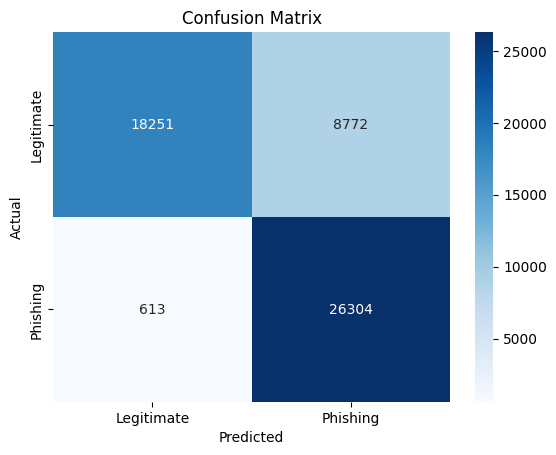

['xgboost_phishing_model.pkl']

In [11]:
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==================== Data Collection ====================
file_path = (r"C:\Users\dinesh\Desktop\PHISHING\PhiUSIIL_Phishing_URL_Dataset.csv")
df = pd.read_csv(file_path)

# Selecting relevant columns
df = df[['URL', 'label']].dropna()
df.rename(columns={"URL": "text"}, inplace=True)

# ==================== Feature Engineering ====================
def extract_features(url):
    return [
        len(url),  # URL length
        url.count('.'),  # Number of dots
        url.count('-'),  # Number of hyphens
        url.count('@'),  # Presence of '@'
        url.count('/'),  # Number of forward slashes
        url.count('?'),  # Presence of query
        url.count('=')  # Presence of equal sign
    ]

df_features = df['text'].apply(lambda x: extract_features(x))
X_features = np.array(df_features.tolist())
y = df['label']

# ==================== Data Balancing with SMOTE ====================
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_features, y)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# ==================== Model Training: XGBoost ====================
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# ==================== Model Evaluation ====================
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the optimized model
joblib.dump(xgb_model, "xgboost_phishing_model.pkl")
